In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/AID')


In [3]:
!ls


Airport        Center		 Farmland	    Mountain	Port		SparseResidential
BareLand       Church		 Forest		    Park	RailwayStation	Square
BaseballField  Commercial	 Industrial	    Parking	Resort		Stadium
Beach	       DenseResidential  Meadow		    Playground	River		StorageTanks
Bridge	       Desert		 MediumResidential  Pond	School		Viaduct


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [5]:
np.random.seed(42)
tf.random.set_seed(42)


In [6]:

data_path = '/content/drive/My Drive/AID'


datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_path,
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2064 images belonging to 30 classes.
Found 516 images belonging to 30 classes.


In [8]:
# @title VGG16


from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(160, 160, 3))


for layer in base_model_vgg16.layers[:-6]:
    layer.trainable = False


x = Flatten()(base_model_vgg16.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(30, activation='softmax')(x)
model = Model(inputs=base_model_vgg16.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


history_vgg16 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)



Epoch 1/10
64/64 [==============================] - 1256s 19s/step - loss: 1.1411 - accuracy: 0.6156 - val_loss: 0.4601 - val_accuracy: 0.8477
Epoch 2/10
64/64 [==============================] - 1069s 17s/step - loss: 0.5102 - accuracy: 0.8342 - val_loss: 0.3892 - val_accuracy: 0.8926
Epoch 3/10
64/64 [==============================] - 1052s 16s/step - loss: 0.3780 - accuracy: 0.8622 - val_loss: 0.3940 - val_accuracy: 0.8691
Epoch 4/10
64/64 [==============================] - 1043s 16s/step - loss: 0.2721 - accuracy: 0.9070 - val_loss: 0.4327 - val_accuracy: 0.8730
Epoch 5/10
64/64 [==============================] - 1073s 17s/step - loss: 0.2813 - accuracy: 0.9021 - val_loss: 0.2696 - val_accuracy: 0.9141
Epoch 6/10
64/64 [==============================] - 1044s 16s/step - loss: 0.2387 - accuracy: 0.9198 - val_loss: 0.3690 - val_accuracy: 0.9023
Epoch 7/10
64/64 [==============================] - 1042s 16s/step - loss: 0.1958 - accuracy: 0.9277 - val_loss: 0.3088 - val_accuracy: 0.9219

'# Evaluate the model on the validation set for VGG-16\nval_loss_vgg16, val_accuracy_vgg16 = model_vgg16.evaluate(\n    validation_generator,\n    steps=validation_generator.samples // validation_generator.batch_size\n)'

In [18]:
model.save('/content/drive/My Drive/vgg16.h5')
model.save_weights('/content/drive/My Drive/vgg16_weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


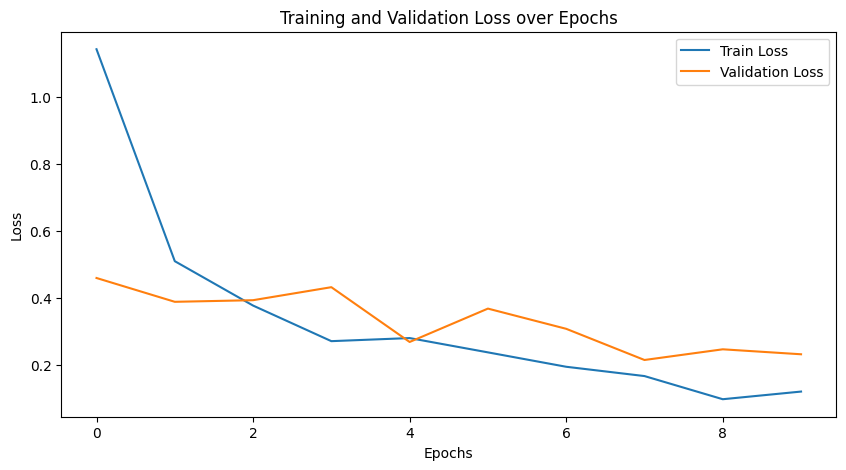

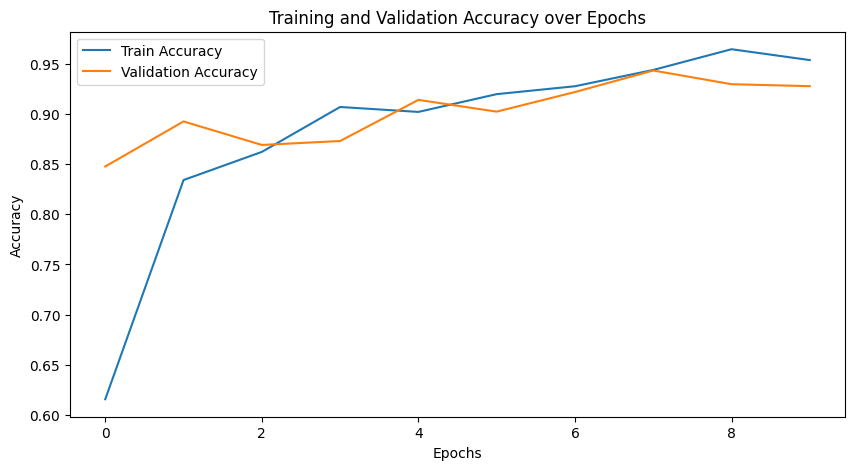

In [31]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_vgg16.history['loss'], label='Train Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(history_vgg16.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [38]:

val_loss_vgg16, val_accuracy_vgg16 = model.evaluate(
    validation_generator,
    steps=validation_generator.samples // validation_generator.batch_size
)

16/16 [==============================] - 152s 10s/step - loss: 0.2035 - accuracy: 0.9434


In [39]:
print(f"Validation Loss for VGG-16: {val_loss_vgg16:.4f}")
print(f"Validation Accuracy for VGG-16: {val_accuracy_vgg16 * 100:.4f}%")


Validation Loss for VGG-16: 0.2035
Validation Accuracy for VGG-16: 94.3359%


In [35]:
validation_generator = datagen.flow_from_directory(
    data_path,
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle = False
)

Found 516 images belonging to 30 classes.


In [36]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def calculate_predictions(model, generator):

    generator.reset()

    predictions = model.predict(generator, steps=np.ceil(generator.samples / generator.batch_size))

    predicted_classes = np.argmax(predictions, axis=1)

    true_classes = generator.classes

    true_classes = true_classes[:len(predicted_classes)]
    return true_classes, predicted_classes


true_classes_vgg16, predicted_classes_vgg16 = calculate_predictions(model, validation_generator)


print("VGG16 Model Evaluation")
print(classification_report(true_classes_vgg16, predicted_classes_vgg16))


print("Confusion Matrix for VGG16")
print(confusion_matrix(true_classes_vgg16, predicted_classes_vgg16))

17/17 [==============================] - 156s 9s/step
VGG16 Model Evaluation
              precision    recall  f1-score   support

           4       0.97      0.97      0.97        72
           5       0.92      0.96      0.94        24
          11       1.00      0.96      0.98        50
          16       0.87      0.89      0.88        70
          18       0.97      0.99      0.98        74
          19       0.93      0.97      0.95        86
          22       0.94      0.83      0.88        58
          23       0.93      0.96      0.95        82

    accuracy                           0.94       516
   macro avg       0.94      0.94      0.94       516
weighted avg       0.94      0.94      0.94       516

Confusion Matrix for VGG16
[[70  0  0  1  0  0  0  1]
 [ 0 23  0  0  1  0  0  0]
 [ 0  0 48  0  0  0  0  2]
 [ 0  1  0 62  0  3  3  1]
 [ 0  0  0  0 73  1  0  0]
 [ 1  0  0  0  1 83  0  1]
 [ 1  1  0  7  0  0 48  1]
 [ 0  0  0  1  0  2  0 79]]


## AlexNet

In [22]:


from tensorflow.keras.layers import Conv2D, MaxPooling2D


model_alexnet = tf.keras.Sequential([
    Conv2D(96, kernel_size=(11, 11), strides=4, activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=2),
    Conv2D(256, kernel_size=(5, 5), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(3, 3), strides=2),
    Conv2D(384, kernel_size=(3, 3), activation='relu', padding="same"),
    Conv2D(384, kernel_size=(3, 3), activation='relu', padding="same"),
    Conv2D(256, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(3, 3), strides=2),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(30, activation='softmax')
])

model_alexnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


history_alexnet = model_alexnet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

Epoch 1/10
64/64 [==============================] - 215s 3s/step - loss: 2.2582 - accuracy: 0.1417 - val_loss: 2.0714 - val_accuracy: 0.1719
Epoch 2/10
64/64 [==============================] - 207s 3s/step - loss: 2.0476 - accuracy: 0.1875 - val_loss: 1.8484 - val_accuracy: 0.2188
Epoch 3/10
64/64 [==============================] - 205s 3s/step - loss: 1.7736 - accuracy: 0.2923 - val_loss: 1.6960 - val_accuracy: 0.2891
Epoch 4/10
64/64 [==============================] - 199s 3s/step - loss: 1.5251 - accuracy: 0.4213 - val_loss: 1.5344 - val_accuracy: 0.3477
Epoch 5/10
64/64 [==============================] - 197s 3s/step - loss: 1.4499 - accuracy: 0.4592 - val_loss: 1.3612 - val_accuracy: 0.4707
Epoch 6/10
64/64 [==============================] - 193s 3s/step - loss: 1.2766 - accuracy: 0.5212 - val_loss: 1.3568 - val_accuracy: 0.4883
Epoch 7/10
64/64 [==============================] - 200s 3s/step - loss: 1.1086 - accuracy: 0.6058 - val_loss: 1.1512 - val_accuracy: 0.5977
Epoch 8/10
64

In [23]:
model_alexnet.save('/content/drive/My Drive/alexnet.h5')
model_alexnet.save_weights('/content/drive/My Drive/alexnet_weights.h5')

In [24]:

val_loss_alexnet, val_accuracy_alexnet = model_alexnet.evaluate(
    validation_generator,
    steps=validation_generator.samples // validation_generator.batch_size
)


16/16 [==============================] - 18s 1s/step - loss: 1.3305 - accuracy: 0.5371


In [25]:

print(f"Validation Loss for AlexNet: {val_loss_alexnet:.4f}")
print(f"Validation Accuracy for AlexNet: {val_accuracy_alexnet:.4f}%")


print("Training history for AlexNet:")
print(f"Loss over epochs: {history_alexnet.history['loss']}")
print(f"Accuracy over epochs: {history_alexnet.history['accuracy']}")
print(f"Validation Loss over epochs: {history_alexnet.history['val_loss']}")
print(f"Validation Accuracy over epochs: {history_alexnet.history['val_accuracy']}")

Validation Loss for AlexNet: 1.3305
Validation Accuracy for AlexNet: 0.5371%
Training history for AlexNet:
Loss over epochs: [2.2582054138183594, 2.04758620262146, 1.7736313343048096, 1.5250928401947021, 1.4498695135116577, 1.2766139507293701, 1.1086431741714478, 1.0780038833618164, 1.0053119659423828, 0.9734511971473694]
Accuracy over epochs: [0.14173229038715363, 0.1875, 0.2923228442668915, 0.4212598502635956, 0.45915353298187256, 0.5211614370346069, 0.6058070659637451, 0.6141732335090637, 0.6343504190444946, 0.6515747904777527]
Validation Loss over epochs: [2.071439027786255, 1.8483946323394775, 1.696030855178833, 1.5343800783157349, 1.3611749410629272, 1.3568096160888672, 1.1512187719345093, 1.1597304344177246, 1.3337806463241577, 1.3312246799468994]
Validation Accuracy over epochs: [0.171875, 0.21875, 0.2890625, 0.34765625, 0.470703125, 0.48828125, 0.59765625, 0.54296875, 0.560546875, 0.52734375]


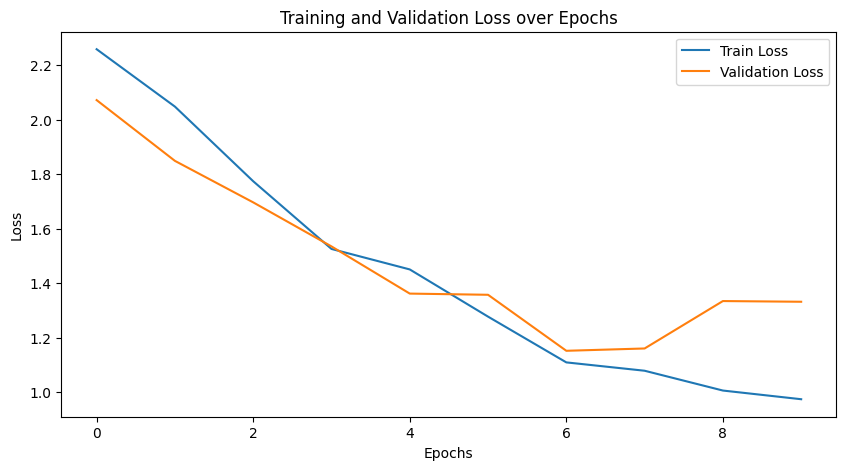

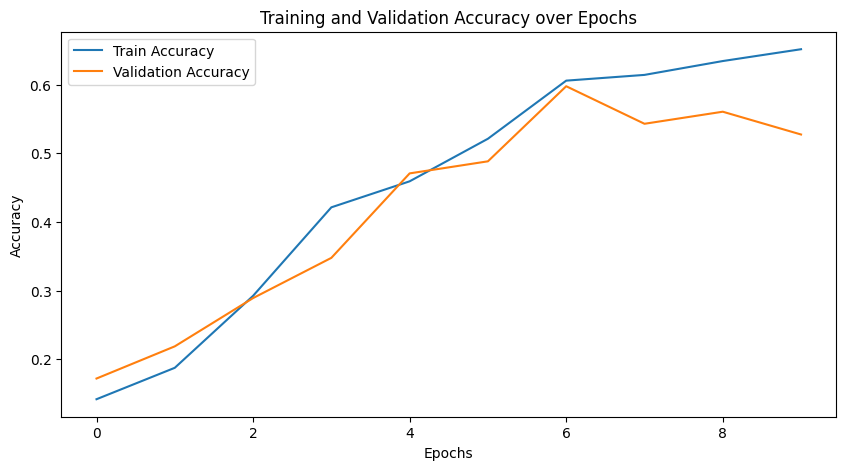

In [27]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(history_alexnet.history['loss'], label='Train Loss')
plt.plot(history_alexnet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(history_alexnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_alexnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [34]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def calculate_predictions(model, generator):

    generator.reset()

    predictions = model.predict(generator, steps=np.ceil(generator.samples / generator.batch_size))

    predicted_classes = np.argmax(predictions, axis=1)

    true_classes = generator.classes

    true_classes = true_classes[:len(predicted_classes)]
    return true_classes, predicted_classes


true_classes_alexnet, predicted_classes_alexnet = calculate_predictions(model_alexnet, validation_generator)


print("AlexNet Model Evaluation")
print(classification_report(true_classes_alexnet, predicted_classes_alexnet))


print("Confusion Matrix for AlexNet")
print(confusion_matrix(true_classes_alexnet, predicted_classes_alexnet))


17/17 [==============================] - 23s 1s/step
AlexNet Model Evaluation
              precision    recall  f1-score   support

           4       0.58      0.39      0.47        72
           5       0.00      0.00      0.00        24
          11       0.52      0.94      0.67        50
          16       0.49      0.79      0.60        70
          18       0.54      0.85      0.66        74
          19       1.00      0.09      0.17        86
          22       0.51      0.84      0.64        58
          23       0.55      0.29      0.38        82

    accuracy                           0.53       516
   macro avg       0.52      0.52      0.45       516
weighted avg       0.59      0.53      0.47       516

Confusion Matrix for AlexNet
[[28  0  8 17  7  0  8  4]
 [ 0  0  0  6  0  0 18  0]
 [ 0  0 47  2  1  0  0  0]
 [ 1  0  3 55  4  0  6  1]
 [ 4  0  0  2 63  0  4  1]
 [13  0  1  7 41  8  2 14]
 [ 2  0  0  6  1  0 49  0]
 [ 0  0 31 18  0  0  9 24]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
